# Report Generation Examples

This notebook demonstrates how to use a custom reporting utility to evaluate a toy signal processing model. We will:
1.  Create a mock signal processing model (a simple low-pass filter).
2.  Generate a synthetic signal with multiple frequency components and noise.
3.  Split the data into training and testing sets.
4.  Use a `ReportGeneration` class to create a summary report with key performance metrics.
5.  Export the test data, model predictions, and calculated metrics to a single CSV file for further analysis.

**Adaptation to recognize the project root. For demonstration purposes only.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ThreeWToolkit.reports.report_generation import ReportGeneration
from ThreeWToolkit.metrics import accuracy_score, f1_score, roc_auc_score, explained_variance_score

## 1. Defining a Mock Model and Generating Data

First, we'll define a `MockSignalModel` that simulates a simple moving average filter. This will act as our "model" for this example.

Then, we'll generate a complex signal composed of a low-frequency sine wave, a higher-frequency sine wave, and some random noise. This mimics a real-world sensor reading, like a vibration sensor.

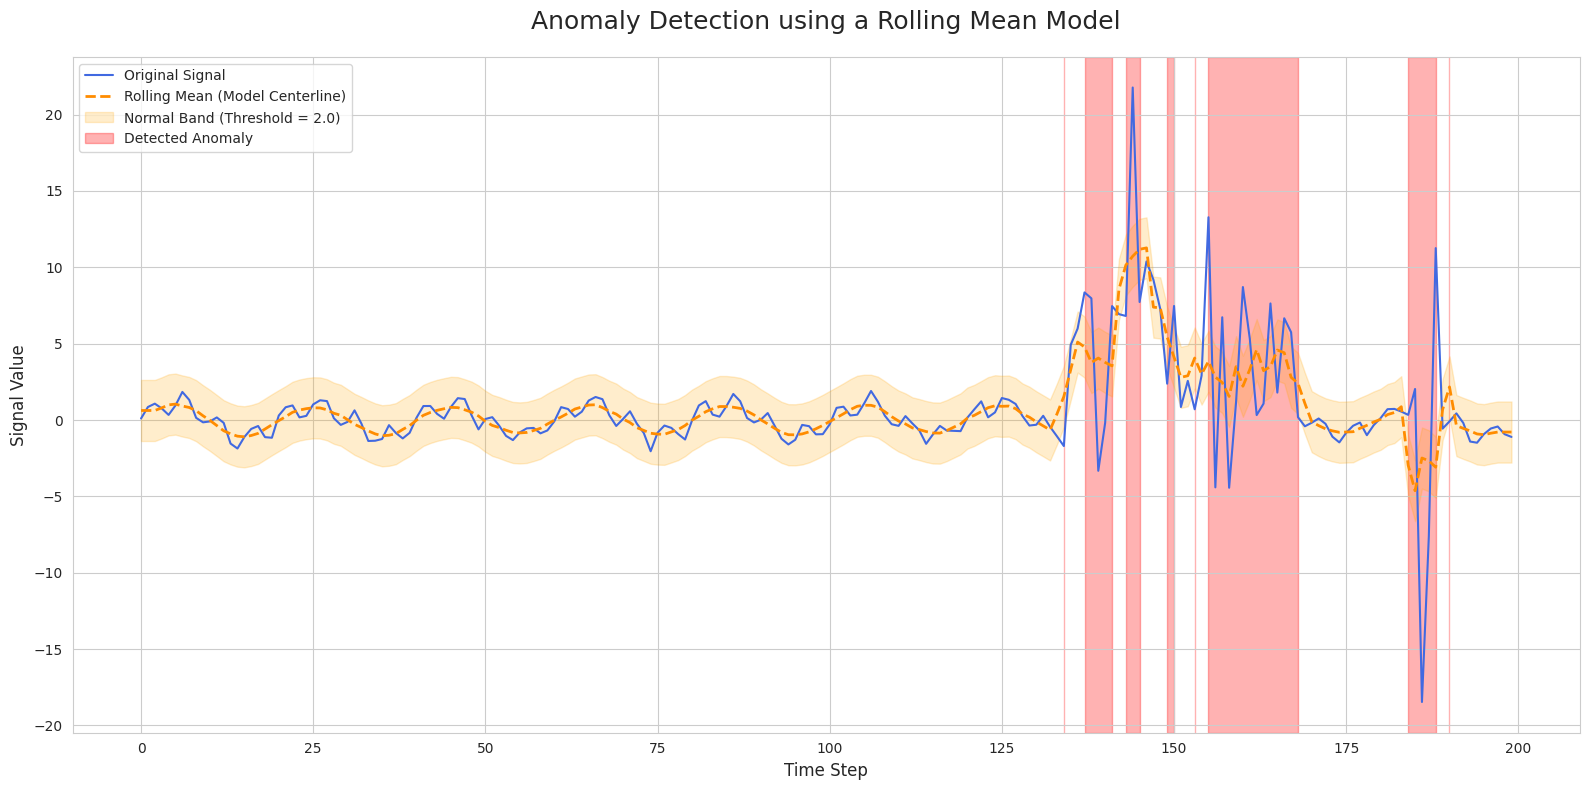

In [2]:

class MockConfig:
    """A mock configuration class to simulate model configuration retrieval."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __iter__(self):
        return iter(self.__dict__.items())

class MockAnomalyModel:
    """A mock model that detects anomalies based on deviation from a rolling mean."""
    def __init__(self, window_size=5, threshold=2.0):
        """Initialize the model with a rolling window size and a threshold for anomaly detection.
        Args:
            window_size (int): The size of the rolling window for smoothing.
            threshold (float): The threshold for detecting anomalies based on deviation from the rolling mean.
        """
        self.window_size = window_size
        self.threshold = threshold

    @property
    def config(self):
        """Return the model's configuration dictionary."""
        return MockConfig(**self.__dict__)

    def get_params(self): 
        """Return the model parameters as a dictionary."""
        params = self.config.__dict__.copy()
        params["method"] = "rolling_mean_threshold"
        return params
        
    def predict(self, X_data): 
        """Predict anomalies in the input time series data.
        Args:
            X_data (pd.Series): The input time series data.
        Returns:
            pd.Series: A binary series where 1 indicates an anomaly and 0 indicates normal behavior
        """
        smoothed_signal = X_data.rolling(window=self.window_size, center=True).mean().bfill().ffill()
        residual = (X_data - smoothed_signal).abs()
        return (residual > self.threshold).astype(int)

# Generate the mock signal
np.random.seed(42) 
time = np.arange(0, 200, 1)
signal = (np.sin(2 * np.pi * time / 20) + 0.6 * np.sin(2 * np.pi * time / 5) + np.random.normal(0, 0.2, len(time)))
signal_series = pd.Series(signal, index=time, name="signal")

# Make anomalies prolonged events
signal_series.iloc[135:168] += np.random.normal(4.0, 4.5, 33) # Sustained pressure spike
signal_series.iloc[185:189] -= np.random.normal(4.0, 7.5, 4) # Sustained pressure drop


# --- NEW: Plotting Function ---

def plot_anomaly_results(ax, signal_series, smoothed_signal, upper_bound, lower_bound, anomalies_pred, params):
    """
    Draws plot of mock signal and anomaly detection indicators.

    Args:
        ax (matplotlib.axes.Axes): The axes object to draw the plot on.
        signal_series (pd.Series): The original time series data.
        smoothed_signal (pd.Series): The smoothed signal (e.g., rolling mean).
        upper_bound (pd.Series): The upper threshold for anomalies.
        lower_bound (pd.Series): The lower threshold for anomalies.
        anomalies_pred (pd.Series): A series of 0s and 1s indicating predictions.
        params (dict): A dictionary of model parameters for labeling.
    """
    ax.plot(signal_series.index, signal_series, color='royalblue', zorder=2, linewidth=1.5, label='Original Signal')

    ax.plot(smoothed_signal.index, smoothed_signal, color='darkorange', linestyle='--', zorder=3, linewidth=2, label='Rolling Mean (Model Centerline)')

    ax.fill_between(
        signal_series.index, 
        lower_bound, 
        upper_bound, 
        color='orange', 
        alpha=0.2, 
        label=f'Normal Band (Threshold = {params["threshold"]})',
        zorder=1
    )

    # Highlight the detected anomalies with vertical shaded regions
    anomaly_indices = anomalies_pred[anomalies_pred == 1].index
    if not anomaly_indices.empty:
        is_anomaly = False
        start = -1
        for idx, is_anom in anomalies_pred.items():
            if is_anom and not is_anomaly:
                start = idx
                is_anomaly = True
            elif not is_anom and is_anomaly:
                end = idx - 1
                ax.axvspan(start, end, color='red', alpha=0.3, zorder=0, label='Detected Anomaly' if start == anomaly_indices[0] else "")
                is_anomaly = False
        if is_anomaly: # Handle case where anomaly is at the very end
            ax.axvspan(start, anomalies_pred.index[-1], color='red', alpha=0.3, zorder=0, label='Detected Anomaly' if start == anomaly_indices[0] else "")
    
    ax.set_title('Anomaly Detection using a Rolling Mean Model', fontsize=18, pad=20)
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Signal Value', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', frameon=True, facecolor='white', framealpha=0.8)


# 1. Prepare the data for plotting and instantiate the model
model = MockAnomalyModel(window_size=5, threshold=2.0)
params = model.get_params()
anomalies_pred = model.predict(signal_series)
smoothed_signal = signal_series.rolling(window=params['window_size'], center=True).mean().bfill().ffill()
upper_bound = smoothed_signal + params['threshold']
lower_bound = smoothed_signal - params['threshold']

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(16, 8))

plot_anomaly_results(
    ax=ax, 
    signal_series=signal_series, 
    smoothed_signal=smoothed_signal, 
    upper_bound=upper_bound, 
    lower_bound=lower_bound, 
    anomalies_pred=anomalies_pred,
    params=params
)

plt.tight_layout()
plt.show()


### Data Splitting and Model Instantiation

We split our signal data into training and testing sets to simulate a standard machine learning workflow. We then create an instance of our `MockSignalModel`.

It's important to note that this mock model is not trainable. The data splitting is done solely to illustrate how the report generation utility works in a typical machine learning context.

In [3]:
# Create ground truth labels to match the prolonged anomalies ---
y_labels = pd.Series(0, index=time, name="is_anomaly")
y_labels.iloc[135:168] = 1  # Label all 33 steps as an anomaly
y_labels.iloc[185:189] = 1  # Label all 4 steps as an anomaly

X_train_ex = signal_series.iloc[:150]
y_train_ex = y_labels.iloc[:150]
X_test_ex = signal_series.iloc[150:]
y_test_ex = y_labels.iloc[150:]

## 2. Generating a Summary Report

Here, we demonstrate the primary function of the reporting utility.

1.  **Define Metrics**: We specify a list of regression and signal-focused metrics we want to compute. These are passed as strings corresponding to method names in a `Metrics` helper class.
2.  **Generate and Save Report**: We call `ReportGeneration.generate_summary_report`, which orchestrates the model evaluation, metric calculation, and plot generation. The resulting report object is then saved to a file (e.g., PDF or HTML).

In [4]:

# Define regression/signal-focused metrics to include
metrics_to_include = {
    "accuracy_score": accuracy_score(y_test_ex, anomalies_pred.iloc[150:]),
    "f1_score": f1_score(y_test_ex, anomalies_pred.iloc[150:]),
    "roc_auc_score": roc_auc_score(y_test_ex, anomalies_pred.iloc[150:]),
    "explained_variance_score": explained_variance_score(y_test_ex, anomalies_pred.iloc[150:])
}

plot_config = {
    "PlotSeries": {
        "series": signal_series,
        "title": "P-TPT",
        "xlabel": "Timestamp",
        "ylabel": "P-TPT",
        "overlay_events": False,
        'color': "green"
    }
}
    # y_true: Union[np.ndarray, pd.Series, list],
    # y_pred: Union[np.ndarray, pd.Series, list],
    # labels: Optional[list] = None,
    # pos_label: Optional[int] = 1,
    # average: Optional[str] = "binary",
    # sample_weight: Optional[Union[np.ndarray, pd.Series, list]] = None,
    # zero_division: Union[str, int] = "warn",


# Use the ReportGeneration class
print("\n### EXECUTING generate_summary_report and save_report ###")

report_generation = ReportGeneration(
    model=model,
    X_train=X_train_ex, 
    y_train=y_train_ex,
    X_test=X_test_ex, 
    y_test=y_test_ex,
    predictions=anomalies_pred.iloc[150:],
    calculated_metrics=metrics_to_include,
    plot_config=plot_config,
    title="Anomaly Analysis Example",
    author="3W Toolkit",
    export_report_after_generate=False
)

html_report = report_generation.generate_summary_report(template_name="report_template.html", format="html")
latex_report = report_generation.generate_summary_report(format="latex")

report_generation.save_report(html_report, "signal_analysis_report", format="html")
report_generation.save_report(latex_report, "signal_analysis_report", format="latex")



### EXECUTING generate_summary_report and save_report ###
Generating Markdown report from template: 'report_template.html'...
DataVisualization: Chart saved to '/home/pedro/Workspace/UFRJ/3W/3WToolkit/output/3w_plots/p-tpt.png'
Markdown report generated successfully.
Generating Beamer report: 'Anomaly Analysis Example'...
DataVisualization: Chart saved to '/home/pedro/Workspace/UFRJ/3W/3WToolkit/output/3w_plots/p-tpt.png'
Beamer document generated successfully.
Saving markdown report to '/home/pedro/Workspace/UFRJ/3W/3WToolkit/output/reports/report-Anomaly Analysis Example/html/signal_analysis_report.html'...
Markdown report saved successfully to '/home/pedro/Workspace/UFRJ/3W/3WToolkit/output/reports/report-Anomaly Analysis Example/html/signal_analysis_report.html'
HTML report saved successfully
Saving report to '/home/pedro/Workspace/UFRJ/3W/3WToolkit/output/reports/report-Anomaly Analysis Example' folder'...
Report saved successfully to 'signal_analysis_report.tex'
Copied .sty file

## 3. Exporting Full Experiment Results to CSV

In addition to a high-level summary report, it's often useful to export the raw data from an experiment for deeper, custom analysis. This includes the test set inputs (`X_test`), the ground truth (`y_test`), and the model's predictions.

Here, we bundle these components along with the calculated metrics into a single dictionary and use the `export_results_to_csv` method to save everything into one convenient file.

In [5]:
predictions_series = model.predict(X_test_ex).to_numpy()

calculated_metrics = {
    "accuracy_score": accuracy_score(y_test_ex, predictions_series),
    "f1_score": f1_score(y_test_ex, predictions_series),
    "roc_auc_score": roc_auc_score(y_test_ex, predictions_series),
    "explained_variance_score": explained_variance_score(y_test_ex, predictions_series)
}
# Bundle all results into a single dictionary
experiment_bundle = {
    "X_test": X_test_ex.to_numpy(),
    "true_values": y_test_ex,
    "predictions": predictions_series,
    "model_name": type(model).__name__,
    "metrics": calculated_metrics  # Pass the list of calculated metrics
}

print(f"Calculated Metrics: {calculated_metrics}")

Calculated Metrics: {'accuracy_score': 0.9, 'f1_score': 0.8888888888888888, 'roc_auc_score': 0.9009740259740261, 'explained_variance_score': 0.5957792207792207}


In [6]:
filename = "full_experiment_results.csv"

report_generation.export_results_to_csv(
    results=experiment_bundle,
    filename=filename
)
print(f"CSV export complete. File saved as {filename}")

Exporting results to 'full_experiment_results.csv'...
Successfully exported results to '/home/pedro/Workspace/UFRJ/3W/3WToolkit/output/reports/report-Anomaly Analysis Example/full_experiment_results.csv'.
CSV export complete. File saved as full_experiment_results.csv
